In [3]:
from sisl import *
import numpy as np
from sisl.io import *
import sisl.viz
# from sisl.viz import merge_plots
import matplotlib.pyplot as plt
from time import time
from scipy import linalg
import os
import h5py

%matplotlib inline

In [182]:
import json
import argparse
import h5py
import numpy as np
import os
from time import time
from scipy.sparse import csc_matrix 
from scipy.linalg import eigh, qr
from scipy.sparse.linalg import eigs
from sisl import *

input_dir = "/fs2/home/ndsim10/DeepH-final/graphene_example/work_dir/inference/graphene450/"
# input_dir = "/fs2/home/ndsim10/DeepH-no-rotate/graphene_example/work_dir/inference/graphene450/"

def _create_dict_h5(filename):
    fid = h5py.File(filename, "r")
    d_out = {}
    for key in fid.keys():
        data = np.array(fid[key])
        nk = tuple(map(int, key[1:-1].split(','))) ##假设键的格式类似于"[0,0,0,2,3]"，key[1:-1]即不读取开头和结尾的括号，然后根据逗号分隔键的内容并转换为整数元组。
        # BS: 
        # the matrix do not need be transposed in Python, 
        # But the transpose should be done in Julia.
        d_out[nk] = data # np.transpose(data)
    fid.close()
    return d_out


ev2Hartree = 0.036749324533634074
Bohr2Ang = 0.529177249


default_dtype = np.complex128 #设置了 NumPy 数组的默认数据类型为复数类型 complex128。在 NumPy 中，数据类型 np.complex128 表示复数，由双精度浮点数构成，即实部和虚部都是双精度浮点数。

if os.path.isfile(os.path.join(input_dir, "info.json")):
    with open(os.path.join(input_dir, "info.json")) as f:
        spinful = json.load(f)["isspinful"] #False
else:
    spinful = False

site_positions = np.loadtxt(os.path.join(input_dir, "site_positions.dat")) #(3,244)原子坐标

if len(site_positions.shape) == 2:
    nsites = site_positions.shape[1] #244
else:
    nsites = 1
    # in case of single atom


with open(os.path.join(input_dir, "orbital_types.dat")) as f: #(244,3)   [[0,1,2],[0,1,2],...,[0,1,2]]
    site_norbits = np.zeros(nsites, dtype=int) #[244个0]
    orbital_types = []
    for index_site in range(nsites):
        orbital_type = list(map(int, f.readline().split()))
        orbital_types.append(orbital_type)
        site_norbits[index_site] = np.sum(np.array(orbital_type) * 2 + 1) #[244个9]
    norbits = np.sum(site_norbits) #244*9=2196
    site_norbits_cumsum = np.cumsum(site_norbits) ##用于计算数组中元素的累积和。它接受一个数组作为输入，并返回一个新的数组，其中每个元素是原数组中对应位置之前所有元素的累积和。返回一个与原始数组大小相同的数组，其中第一个元素是原数组的第一个元素，第二个元素是原数组的前两个元素之和，以此类推。
    #site_norbits_cumsum:[9   18   27 ... 2196]

rlat = np.loadtxt(os.path.join(input_dir, "rlat.dat")).T #读取倒格矢(3,3)
# require transposition while reading rlat.dat in python


print("read h5")
begin_time = time()
hamiltonians_pred = _create_dict_h5(os.path.join(input_dir, "hamiltonians_pred.h5")) #读取预测的哈密顿量矩阵
overlaps = _create_dict_h5(os.path.join(input_dir, "overlaps.h5")) #读取siesta_get_data预先计算的重叠矩阵
print("Time for reading h5: ", time() - begin_time, "s")

H_pred_R = {}
S_R = {}

print("construct Hamiltonian and overlap matrix in the real space")
begin_time = time()

for key in hamiltonians_pred.keys():
    hamiltonian_pred = hamiltonians_pred[key] #读取预测的每一个key的哈密顿量矩阵
    if key in overlaps.keys(): #预测哈密顿量矩阵的key，在重叠矩阵的key中，则读取对应key的重叠矩阵，否则生成一个类哈密顿量矩阵的0矩阵
        overlap = overlaps[key]
    else:
        overlap = np.zeros_like(hamiltonian_pred)
    if spinful: #如果存在自旋，构建自旋的重叠矩阵
        overlap = np.vstack((np.hstack((overlap, np.zeros_like(overlap))), np.hstack((np.zeros_like(overlap), overlap))))
    R = key[:3] #读取key中的R，即原子所属的晶胞的索引
    atom_i = key[3] - 1 #读取在晶胞R中存在连接的原子i和原子j
    atom_j = key[4] - 1
    assert (site_norbits[atom_i], site_norbits[atom_j]) == hamiltonian_pred.shape #(9,9)的矩阵
    assert (site_norbits[atom_i], site_norbits[atom_j]) == overlap.shape #(9,9)的矩阵
    if R not in H_pred_R.keys(): #True
        H_pred_R[R] = np.zeros((norbits, norbits), dtype=default_dtype) #(2196,2196)的数据类型为复数类型complex128的零矩阵，存放实空间的哈密顿量矩阵和重叠矩阵
        S_R[R] = np.zeros((norbits, norbits), dtype=default_dtype)
    for block_matrix_i in range(1, site_norbits[atom_i]+1): #1-9
        for block_matrix_j in range(1, site_norbits[atom_j]+1): #1-9
            index_i = site_norbits_cumsum[atom_i] - site_norbits[atom_i] + block_matrix_i - 1 #key中R对应的是轨道所属的晶胞索引，这里是求得原子i所在晶胞内的实际原子轨道
            index_j = site_norbits_cumsum[atom_j] - site_norbits[atom_j] + block_matrix_j - 1
            H_pred_R[R][index_i, index_j] = hamiltonian_pred[block_matrix_i-1, block_matrix_j-1] #将两个原子的轨道对的预测的的哈密顿量值填充到H_R[R]中，H_R[R]是（244*9=2196）*（244*9=2196）
            S_R[R][index_i, index_j] = overlap[block_matrix_i-1, block_matrix_j-1] #将两个原子对的重叠矩阵值填充到S_R[R]中

#到这里就得到了实空间的哈密顿矩阵H_R和重叠矩阵S_R
print("Time for constructing Hamiltonian and overlap matrix in the real space: ", time() - begin_time, " s")

read h5
Time for reading h5:  13.651597738265991 s
construct Hamiltonian and overlap matrix in the real space
Time for constructing Hamiltonian and overlap matrix in the real space:  8.858622074127197  s


In [243]:
import json
import argparse
import h5py
import numpy as np
import os
from time import time
from scipy.sparse import csc_matrix
from scipy.linalg import eigh, qr
from scipy.sparse.linalg import eigs
from sisl import *

input_dir = "/fs2/home/ndsim10/DeepH-final/graphene_example/work_dir/inference/graphene450/"



print("Time for reading h5: ", time() - begin_time, "s")

def _create_dict_h5(filename):
    fid = h5py.File(filename, "r")
    d_out = {}
    for key in fid.keys():
        data = np.array(fid[key])
        nk = tuple(map(int, key[1:-1].split(','))) ##假设键的格式类似于"[0,0,0,2,3]"，key[1:-1]即不读取开头和结尾的括号，然后根据逗号分隔键的内容并转换为整数元组。
        # BS: 
        # the matrix do not need be transposed in Python, 
        # But the transpose should be done in Julia.
        d_out[nk] = data # np.transpose(data)
    fid.close()
    return d_out


ev2Hartree = 0.036749324533634074
Bohr2Ang = 0.529177249


def genlist(x):
    return np.linspace(x[0], x[1], int(x[2]), endpoint=False)


def k_data2num_ks(kdata):
    return int(kdata.split()[0])


def k_data2kpath(kdata):
    return [float(x) for x in kdata.split()[1:7]]


def std_out_array(a):
    return ''.join([str(x) + ' ' for x in a])

def std_out_EKarray(E_K):
    output = ""  # 初始化一个空字符串，用于累加每行的字符串表示
    for ek in E_K:
        line = ''.join(str(x)+" " for x in ek) + "\n"  # 将一行转换为字符串并加上换行符
        output += line  # 将这一行添加到输出字符串中
    return output

def str_to_bool(s):
    tmp = bool()
    if s == "True":
        tmp = True
    elif s == "False":
        tmp = False
    else:
        raise ValueError(f"Unknown calulate job: {s}")
    return tmp

def constructmeshkpts(nkmesh, offset=[0.0, 0.0, 0.0], k1=[0.0, 0.0, 0.0], k2=[1.0, 1.0, 1.0]):
    if len(nkmesh) != 3:
        raise ValueError("nkmesh must be of size 3.")
    nkpts = np.prod(nkmesh)
    kpts = np.zeros((3, nkpts))
    ik = 0
    for ikx in range(nkmesh[0]):
        for iky in range(nkmesh[1]):
            for ikz in range(nkmesh[2]):
                kpts[:, ik] = [
                    (ikx / nkmesh[0]) * (k2[0] - k1[0]) + k1[0],
                    (iky / nkmesh[1]) * (k2[1] - k1[1]) + k1[1],
                    (ikz / nkmesh[2]) * (k2[2] - k1[2]) + k1[2]
                ]
                ik += 1
    return kpts + np.array(offset).reshape(3, 1)


default_dtype = np.complex128 #设置了 NumPy 数组的默认数据类型为复数类型 complex128。在 NumPy 中，数据类型 np.complex128 表示复数，由双精度浮点数构成，即实部和虚部都是双精度浮点数。

# 假设你的 JSON 文件名为 band.json
with open(input_dir+'band.json', 'r') as file:
    config = json.load(file)
# 打印读取的内容
print(config)
calc_bands = str_to_bool(config["calc_bands"]) #band，这里可以改为True或False
calc_dos = str_to_bool(config["calc_dos"]) #band，这里可以改为True或False


if os.path.isfile(os.path.join(input_dir, "info.json")):
    with open(input_dir+'info.json', 'r') as f:
        spinful = json.load(f)["isspinful"] #False
else:
    spinful = False

site_positions = np.loadtxt(os.path.join(input_dir, "site_positions.dat")) #(3,244)原子坐标

if len(site_positions.shape) == 2:
    nsites = site_positions.shape[1] #244
else:
    nsites = 1
    # in case of single atom


with open(os.path.join(input_dir, "orbital_types.dat")) as f: #(244,3)   [[0,1,2],[0,1,2],...,[0,1,2]]
    site_norbits = np.zeros(nsites, dtype=int) #[244个0]
    orbital_types = []
    for index_site in range(nsites):
        orbital_type = list(map(int, f.readline().split()))
        orbital_types.append(orbital_type)
        site_norbits[index_site] = np.sum(np.array(orbital_type) * 2 + 1) #[244个9]
    norbits = np.sum(site_norbits) #244*9=2196
    site_norbits_cumsum = np.cumsum(site_norbits) ##用于计算数组中元素的累积和。它接受一个数组作为输入，并返回一个新的数组，其中每个元素是原数组中对应位置之前所有元素的累积和。返回一个与原始数组大小相同的数组，其中第一个元素是原数组的第一个元素，第二个元素是原数组的前两个元素之和，以此类推。
    #site_norbits_cumsum:[9   18   27 ... 2196]
# print(norbits)
# print(site_norbits_cumsum)
rlat = np.loadtxt(os.path.join(input_dir, "rlat.dat")).T #读取倒格矢(3,3)
# require transposition while reading rlat.dat in python

print("read h5")
begin_time = time()
hamiltonians_pred = _create_dict_h5(os.path.join(input_dir, "hamiltonians_pred.h5")) #读取预测的哈密顿量矩阵
overlaps = _create_dict_h5(os.path.join(input_dir, "overlaps.h5")) #读取siesta_get_data预先计算的重叠矩阵
print("Time for reading h5: ", time() - begin_time, "s")


H_R = {}
S_R = {}

print("construct Hamiltonian and overlap matrix in the real space")
begin_time = time()

# BS:
# this is for debug python and julia
# in julia, you can use 'sort(collect(keys(hamiltonians_pred)))'
# for key in dict(sorted(hamiltonians_pred.items())).keys():
for key in hamiltonians_pred.keys():

    hamiltonian_pred = hamiltonians_pred[key] #读取预测的每一个key的哈密顿量矩阵

    if key in overlaps.keys(): #预测哈密顿量矩阵的key，在重叠矩阵的key中，则读取对应key的重叠矩阵，否则生成一个类哈密顿量矩阵的0矩阵
        overlap = overlaps[key]
    else:
        overlap = np.zeros_like(hamiltonian_pred)
    if spinful: #如果存在自旋，构建自旋的重叠矩阵
        overlap = np.vstack((np.hstack((overlap, np.zeros_like(overlap))), np.hstack((np.zeros_like(overlap), overlap))))
    R = key[:3] #读取key中的R，即原子所属的晶胞的索引
    atom_i = key[3] - 1 #读取在晶胞R中存在连接的原子i和原子j
    atom_j = key[4] - 1

    assert (site_norbits[atom_i], site_norbits[atom_j]) == hamiltonian_pred.shape #(9,9)的矩阵
    assert (site_norbits[atom_i], site_norbits[atom_j]) == overlap.shape #(9,9)的矩阵

    if R not in H_R.keys(): #True
        H_R[R] = np.zeros((norbits, norbits), dtype=default_dtype) #(2196,2196)的数据类型为复数类型complex128的零矩阵，存放实空间的哈密顿量矩阵和重叠矩阵
        S_R[R] = np.zeros((norbits, norbits), dtype=default_dtype)

    for block_matrix_i in range(1, site_norbits[atom_i]+1): #1-9
        for block_matrix_j in range(1, site_norbits[atom_j]+1): #1-9
            index_i = site_norbits_cumsum[atom_i] - site_norbits[atom_i] + block_matrix_i - 1 #key中R对应的是轨道所属的晶胞索引，这里是求得原子i所在晶胞内的实际原子轨道
            index_j = site_norbits_cumsum[atom_j] - site_norbits[atom_j] + block_matrix_j - 1
            H_R[R][index_i, index_j] = hamiltonian_pred[block_matrix_i-1, block_matrix_j-1] #将两个原子的轨道对的预测的的哈密顿量值填充到H_R[R]中，H_R[R]是（244*9=2196）*（244*9=2196）
            S_R[R][index_i, index_j] = overlap[block_matrix_i-1, block_matrix_j-1] #将两个原子对的重叠矩阵值填充到S_R[R]中
#到这里就得到了实空间的哈密顿矩阵H_R和重叠矩阵S_R
print("Time for constructing Hamiltonian and overlap matrix in the real space: ", time() - begin_time, " s")


if calc_bands == True:
    fermi_level = config["fermi_level"] #-3.82373，这里的费米能级可以计算出来
    k_data = config["k_data"] #["15 0 0 0 0.5 0 0 Γ M", "15 0.5 0 0 0.3333333 0.33333333 0 M K", "15 0.33333333 0.33333333 0 0 0 0 K Γ"]
    # print("k_data",k_data)

    print("calculate bands")
    num_ks = [k_data2num_ks(k) for k in k_data] #[15,15,15]
    kpaths = [k_data2kpath(k) for k in k_data] #[[0 0 0 0.5 0 0],[0.5 0 0 0.3333333 0.33333333 0],[0.33333333 0.33333333 0 0 0 0]]

    egvals = np.zeros((norbits, sum(num_ks)+1)) #(2196,46)，构建了k点下存放特征值的零矩阵

    begin_time = time()

    k_points = np.empty((1,3))
    for i in range(len(kpaths)): #0-2
        kpath = kpaths[i]
        pnkpts = num_ks[i]
        kxs = np.linspace(kpath[0], kpath[3], pnkpts, endpoint=False) #创建了一个在闭区间 [start, end] 上均匀分布的等差数列，包含了 pnkpts 个元素。
        kys = np.linspace(kpath[1], kpath[4], pnkpts, endpoint=False)
        kzs = np.linspace(kpath[2], kpath[5], pnkpts, endpoint=False)
        matrix = np.column_stack((kxs, kys, kzs))
        k_points = np.vstack((k_points, matrix))
    k_points = np.delete(k_points, 0, axis=0)
    k_points = np.vstack((k_points, np.array(kpaths[len(kpaths)-1][3:])))
    # print(k_points)
    # print(k_points.shape) #46*3
    idx_k = 0
    for i in range(len(k_points)): #同时迭代处理这三个列表中对应位置的元素。
        kx, ky, kz = k_points[i,:]
        H_k = np.zeros((norbits, norbits), dtype=default_dtype) #(2196,2196)的数据类型为复数类型complex128的零矩阵，存放实空间的哈密顿量矩阵和重叠矩阵
        S_k = np.zeros((norbits, norbits), dtype=default_dtype)
        for R in H_R.keys(): #下面两个表达式的意思可能是在k（动量）空间中，通过加权计算不同晶格向量位置上的哈密顿量矩阵，并将结果累加到 H_k 中。
            H_k += H_R[R] * np.exp(1j*2*np.pi*np.dot([kx, ky, kz], R)) #np.dot两个向量的点积运算。点积（内积）操作将这两个向量对应位置的元素相乘，然后将所有相乘结果相加得到一个标量值。这个结果表示了两个向量之间的投影关系和相似性。
            S_k += S_R[R] * np.exp(1j*2*np.pi*np.dot([kx, ky, kz], R)) #复数值为np.exp(1j*2*np.pi*np.dot([kx, ky, kz], R))。
        #---------------------------------------------
        # BS: only eigenvalues are needed in this part,
        # the upper matrix is used
        #
        # egval, egvec = linalg.eig(H_k, S_k)
        egval = linalg.eigvalsh(H_k, S_k, lower=False) #使用了SciPy中linalg.eigvalsh()函数来计算一个Hermitean（厄米特）矩阵H_k的特征值。同时，它指定了矩阵S_k作为正交矩阵，用于进行特征值计算。返回一个数组egval，其中包含了H_k的特征值。参数lower=False表示计算所有的特征值，且这些特征值按照升序排列。
        egvals[:, idx_k] = egval #这里只计算了一个路径下一个k点的特征值，每一列是某一个k点下的所有特征值2196个。所以每一行就是一条能带！2196*46

        print("Time for solving No.{} eigenvalues at k = {} : {} s".format(idx_k+1, [kx, ky, kz], time() - begin_time))
        idx_k += 1 #计算其它路径下k点的特征值

    begin_time = time()

    spin=int(spinful)+1
    siesta_rlat = np.array(rlat * Bohr2Ang) #(3,3)倒格矢
    ymin = egvals.min() #-14.065387633674039
    ymax = egvals.max() #17.63961205616035
    # print(ymin, ymax)

    # output in siesta band format
    with open(os.path.join(input_dir, "pred_bands.dat"), "w") as f:
        kpoint = 0.000000
        k_list = [0.000000]
        for i in range(len(k_points)-1):  # 同时迭代处理这三个列表中对应位置的元素。
            kvec0 = k_points[i, :]
            kvec1 = k_points[i + 1, :]
            kpoint = np.linalg.norm(kvec0 @ siesta_rlat - kvec1 @ siesta_rlat) + kpoint
            k_list.append(np.around(kpoint, decimals=6))
        # print("kpoint = ", k_list)
        assert len(k_list) == len(k_points)

        f.write("# ----------------------------------------------------------------\n")
        f.write("# E_F\t=\t{}\n".format(fermi_level))  # -3.82373
        f.write("# k_min, k_max\t=\t{}\t{}\n".format(k_list[0], k_list[-1]))
        f.write("# E_min, E_max\t=\t{}\t{}\n".format(ymin, ymax))
        f.write("# Nbands, Nspin, Nk\t=\t{}\t{}\t{}\n".format(norbits, spin, len(k_list)))  # 2196 某个k点的坐标
        f.write("# k\tE[eV]\n")
        f.write("# ----------------------------------------------------------------\n")

        for i in range(len(egvals)):  # 同时迭代处理这三个列表中对应位置的元素。
            E_K = np.column_stack((np.array(k_list), egvals[i, :])) #写入每个k点的特征值，已校归零到费米能级
            f.write(std_out_EKarray(E_K) + "\n\n")
    print("Time for generate siesta band structure data: {} s".format(time() - begin_time))


Time for reading h5:  293.4949059486389 s
{'calc_bands': 'True', 'calc_dos': 'True', 'which_k': 0, 'fermi_level': -3.651819, 'max_iter': 300, 'num_band': 46, 'k_data': ['15 0 0 0 0.5 0 0 Γ M', '15 0.5 0 0 0.33333333 0.33333333 0 M K', '15 0.33333333 0.33333333 0 0 0 0 K Γ']}
5850
[  13   26   39   52   65   78   91  104  117  130  143  156  169  182
  195  208  221  234  247  260  273  286  299  312  325  338  351  364
  377  390  403  416  429  442  455  468  481  494  507  520  533  546
  559  572  585  598  611  624  637  650  663  676  689  702  715  728
  741  754  767  780  793  806  819  832  845  858  871  884  897  910
  923  936  949  962  975  988 1001 1014 1027 1040 1053 1066 1079 1092
 1105 1118 1131 1144 1157 1170 1183 1196 1209 1222 1235 1248 1261 1274
 1287 1300 1313 1326 1339 1352 1365 1378 1391 1404 1417 1430 1443 1456
 1469 1482 1495 1508 1521 1534 1547 1560 1573 1586 1599 1612 1625 1638
 1651 1664 1677 1690 1703 1716 1729 1742 1755 1768 1781 1794 1807 1820
 1833 184

In [244]:
egvals.shape

(5850, 46)

In [371]:
import numpy as np

# 输入参数
num_kpoints = egvals.shape[1]  # 示例数据（需替换为实际数据）
total_electrons = 1800            # 需用户提供实际值
k_weights = np.ones(num_kpoints) / num_kpoints      # 均匀k点权重（可选）

# 展平本征值并附加权重
weighted_energies = []
for k_idx in range(num_kpoints):
    energies = egvals[:, k_idx]          # 当前k点的所有本征值
    weights = np.full_like(energies, k_weights[k_idx])  # 当前k点的权重
    weighted_energies.extend(zip(energies, weights))

# 转换为数组并按能量排序
weighted_energies = np.array(weighted_energies, dtype=[('energy', 'f8'), ('weight', 'f8')])
weighted_energies.sort(order='energy')  # 按能量升序排列

# 累积权重直到达到总电子数
cumulative_weight = np.cumsum(weighted_energies['weight'])
fermi_index = np.searchsorted(cumulative_weight, total_electrons / 2)  # 考虑自旋，每个态最多2电子
e_fermi = weighted_energies['energy'][fermi_index]

print(f"费米能级 E_F = {e_fermi:.4f} eV")

费米能级 E_F = -3.6664 eV


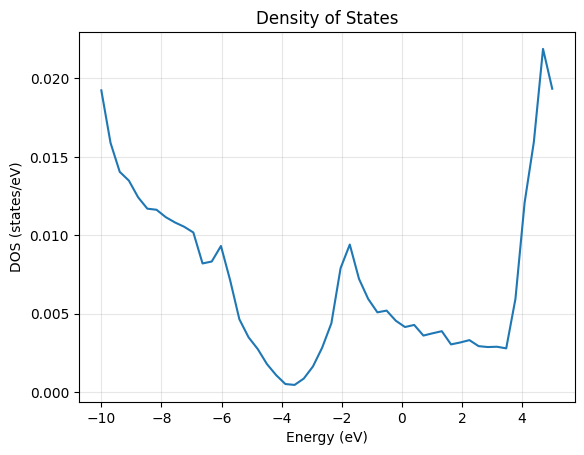

In [380]:
# 高斯展宽法求态密度
import numpy as np
egvals_flat = egvals.flatten()  # 形状变为 (5850*46, )
# emin, emax = np.min(egvals_flat), np.max(egvals_flat)
emin, emax = -10.0, 5.0
energy_grid = np.linspace(emin, emax, 50)  # 调整范围和点数
sigma = 0.2  # 展宽参数（根据体系调整，半导体/金属需不同）
dos = np.zeros_like(energy_grid)

for eig in egvals_flat:
    dos += np.exp(-0.5 * ((energy_grid - eig) / sigma)**2) / (sigma * np.sqrt(2 * np.pi))

dos /= len(egvals_flat)  # 归一化（总积分为1）
# weights = np.ones(46) / 46  # 假设均匀权重（根据实际修改）
# egvals_weighted = (egvals * weights.reshape(1, -1)).flatten()
# 后续步骤替换 egvals_flat 为 egvals_weighted
import matplotlib.pyplot as plt

plt.plot(energy_grid, dos, lw=1.5)
plt.xlabel('Energy (eV)')
plt.ylabel('DOS (states/eV)')
plt.title('Density of States')
plt.grid(alpha=0.3)
plt.show()

In [377]:
energy_grid.shape

(50,)

In [378]:
dos.shape

(50,)

In [379]:
np.column_stack((energy_grid, dos))

array([[-1.00000000e+01,  1.92422655e-02],
       [-9.69387755e+00,  1.58950722e-02],
       [-9.38775510e+00,  1.40451109e-02],
       [-9.08163265e+00,  1.34810802e-02],
       [-8.77551020e+00,  1.24187736e-02],
       [-8.46938776e+00,  1.16946530e-02],
       [-8.16326531e+00,  1.16251020e-02],
       [-7.85714286e+00,  1.11548356e-02],
       [-7.55102041e+00,  1.08171162e-02],
       [-7.24489796e+00,  1.05422959e-02],
       [-6.93877551e+00,  1.01767511e-02],
       [-6.63265306e+00,  8.20044437e-03],
       [-6.32653061e+00,  8.32431870e-03],
       [-6.02040816e+00,  9.31562884e-03],
       [-5.71428571e+00,  7.12571732e-03],
       [-5.40816327e+00,  4.64304930e-03],
       [-5.10204082e+00,  3.49115453e-03],
       [-4.79591837e+00,  2.73894598e-03],
       [-4.48979592e+00,  1.78177525e-03],
       [-4.18367347e+00,  1.07594195e-03],
       [-3.87755102e+00,  5.10275011e-04],
       [-3.57142857e+00,  4.52999680e-04],
       [-3.26530612e+00,  8.58212804e-04],
       [-2.

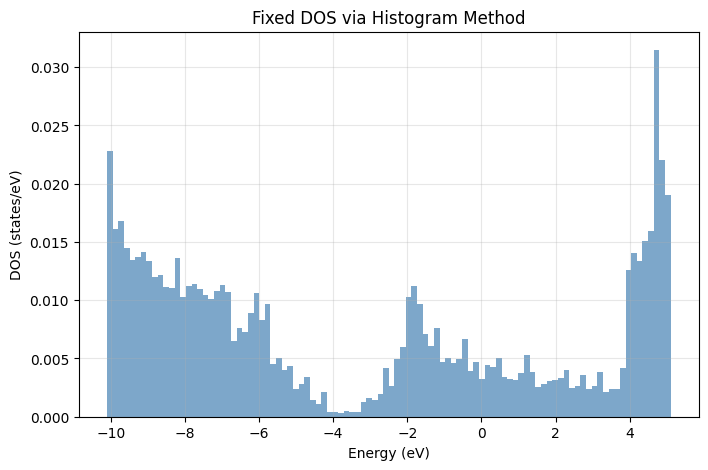

In [367]:
import numpy as np
import matplotlib.pyplot as plt

# 输入数据：egvals.shape = (5850, 46)
egvals_flat = egvals.flatten()

# 定义能量范围和分箱数
# emin, emax = np.min(egvals_flat), np.max(egvals_flat)
emin, emax = -10.0, 5.0
n_bins = 100  # 分箱数

# 优化分箱定义（避免截断数据）
energy_edges = np.linspace(emin - 0.1, emax + 0.1, n_bins + 1)  # 形状 (1001,)

# 计算直方图统计
counts, bin_edges = np.histogram(egvals_flat, bins=energy_edges, density=False)

# 正确计算分箱宽度（核心修复）
delta_e = np.diff(bin_edges)  # 形状 (1000,)，每个分箱的实际宽度

# 计算态密度（逐分箱归一化）
total_states = len(egvals_flat)
dos = counts / (total_states * delta_e)  # 形状 (1000,)

# 可视化
plt.figure(figsize=(8, 5))
plt.stairs(dos, bin_edges, fill=True, color='steelblue', alpha=0.7)
plt.xlabel('Energy (eV)')
plt.ylabel('DOS (states/eV)')
plt.title('Fixed DOS via Histogram Method')
plt.grid(alpha=0.3)
plt.show()

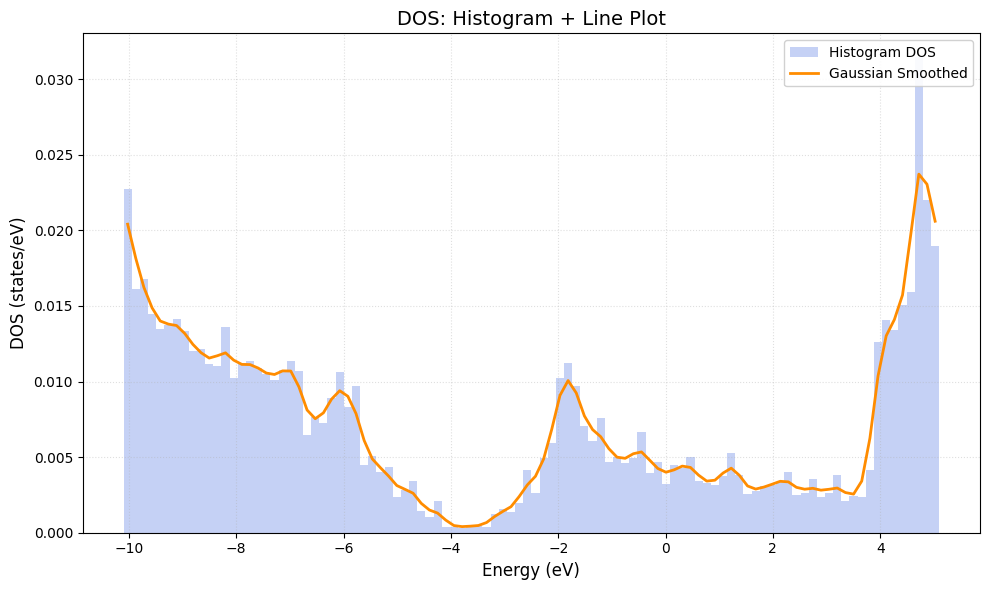

In [369]:
import numpy as np
import matplotlib.pyplot as plt

# 输入数据展平
egvals_flat = egvals.flatten()

# 分箱参数设置
# emin, emax = np.min(egvals_flat), np.max(egvals_flat)
emin, emax = -10.0, 5.0
n_bins = 100
energy_edges = np.linspace(emin - 0.1, emax + 0.1, n_bins + 1)

# 计算直方图统计
counts, bin_edges = np.histogram(egvals_flat, bins=energy_edges, density=False)
delta_e = np.diff(bin_edges)
dos = counts / (len(egvals_flat) * delta_e)

# 计算分箱中心坐标（关键新增代码）
x_mid = (bin_edges[:-1] + bin_edges[1:]) / 2  # 形状 (1000,)



# 可视化叠加
plt.figure(figsize=(10, 6))
# 绘制直方图（填充色）
plt.stairs(dos, bin_edges, fill=True, color='royalblue', alpha=0.3, label='Histogram DOS')


from scipy.ndimage import gaussian_filter1d
dos_smoothed = gaussian_filter1d(dos, sigma=1.0)  # sigma控制平滑强度
plt.plot(x_mid, dos_smoothed, color='darkorange', linewidth=2, label='Gaussian Smoothed')
# 叠加折线图（红色曲线）
# plt.plot(x_mid, dos, color='crimson', linewidth=1.5, alpha=0.8, label='Smoothed DOS')

# 图例与样式
plt.xlabel('Energy (eV)', fontsize=12)
plt.ylabel('DOS (states/eV)', fontsize=12)
plt.title('DOS: Histogram + Line Plot', fontsize=14)
plt.legend(loc='upper right', framealpha=0.9)
plt.grid(linestyle=':', alpha=0.4)

plt.tight_layout()
plt.show()


In [183]:
geom = sisl.get_sile("/fs2/home/ndsim10/DeepH-final/graphene_example/work_dir/olp/graphene450/input.fdf").read_geometry()
hsx = hsxSileSiesta("/fs2/home/ndsim10/DeepH-final/graphene_example/work_dir/olp/graphene450/graphene450.HSX")
H = hsx.read_hamiltonian(geometry=geom)
S = hsx.read_overlap(geometry=geom) #这个方式是单独读取出重叠矩阵，与H.S的值相同。
print(H)

Hamiltonian{non-zero: 2770650, orthogonal: False,
 Spin{unpolarized, kind=f},
 Geometry{na: 450, no: 5850,
  Atoms{species: 1,
   Atom{C, Z: 6, mass(au): 12.01000, maxR: 2.54640,
    AtomicOrbital{2sZ1, q0: 2.0, SphericalOrbital{l: 0, R: 2.1216000000000035, q0: 2.0}},
    AtomicOrbital{2sZ2, q0: 0.0, SphericalOrbital{l: 0, R: 1.6771999999999991, q0: 0.0}},
    AtomicOrbital{2pyZ1, q0: 0.6666666666666666, SphericalOrbital{l: 1, R: 2.527400000000016, q0: 2.0}},
    AtomicOrbital{2pzZ1, q0: 0.6666666666666666, SphericalOrbital{l: 1, R: 2.527400000000016, q0: 2.0}},
    AtomicOrbital{2pxZ1, q0: 0.6666666666666666, SphericalOrbital{l: 1, R: 2.527400000000016, q0: 2.0}},
    AtomicOrbital{2pyZ2, q0: 0.0, SphericalOrbital{l: 1, R: 1.7504, q0: 0.0}},
    AtomicOrbital{2pzZ2, q0: 0.0, SphericalOrbital{l: 1, R: 1.7504, q0: 0.0}},
    AtomicOrbital{2pxZ2, q0: 0.0, SphericalOrbital{l: 1, R: 1.7504, q0: 0.0}},
    AtomicOrbital{3dxyZ1P, q0: 0.0, SphericalOrbital{l: 2, R: 2.546400000000014, q0: 0.0}

In [4]:
geom = sisl.get_sile("/fs2/home/ndsim10/graphene-defect/Pristine/TS_0.0/input.fdf").read_geometry()
hsx = hsxSileSiesta("/fs2/home/ndsim10/graphene-defect/Pristine/TS_0.0/siesta.HSX")
H = hsx.read_hamiltonian(geometry=geom)
S = hsx.read_overlap(geometry=geom) #这个方式是单独读取出重叠矩阵，与H.S的值相同。
print(H)

Hamiltonian{non-zero: 1182144, orthogonal: False,
 Spin{unpolarized, kind=f},
 Geometry{na: 192, no: 2496,
  Atoms{species: 1,
   Atom{C, Z: 6, mass(au): 12.01000, maxR: 2.53660,
    AtomicOrbital{2sZ1, q0: 2.0, SphericalOrbital{l: 0, R: 2.1092000000000195, q0: 2.0}},
    AtomicOrbital{2sZ2, q0: 0.0, SphericalOrbital{l: 0, R: 1.6849999999999994, q0: 0.0}},
    AtomicOrbital{2pyZ1, q0: 0.6666666666666666, SphericalOrbital{l: 1, R: 2.5100000000000215, q0: 2.0}},
    AtomicOrbital{2pzZ1, q0: 0.6666666666666666, SphericalOrbital{l: 1, R: 2.5100000000000215, q0: 2.0}},
    AtomicOrbital{2pxZ1, q0: 0.6666666666666666, SphericalOrbital{l: 1, R: 2.5100000000000215, q0: 2.0}},
    AtomicOrbital{2pyZ2, q0: 0.0, SphericalOrbital{l: 1, R: 1.7653999999999994, q0: 0.0}},
    AtomicOrbital{2pzZ2, q0: 0.0, SphericalOrbital{l: 1, R: 1.7653999999999994, q0: 0.0}},
    AtomicOrbital{2pxZ2, q0: 0.0, SphericalOrbital{l: 1, R: 1.7653999999999994, q0: 0.0}},
    AtomicOrbital{3dxyZ1P, q0: 0.0, SphericalOrbit

In [5]:
print(H.H.shape)
t = 0
for i in range(0,350):
    print("real_H_{}_{} = {}".format(t,i,H.H[t,i]))
print("====================================================")
print(H_pred_R.keys())
print(H_pred_R[(0, 0, 0)].shape)
#由于预测的哈密顿量轨道和sisl包中的轨道排序不同，因此预测出的哈密顿量矩阵不sisl包读取的哈密顿量矩阵不同，但重叠矩阵相同，因此不用交换轨道
for i in range(100):
    print("pred_H_{}_{} = {}".format(t,i,H_pred_R[(0, 0, 0)][t,i].real))

(2496, 22464, 2)
real_H_0_0 = -16.696346282958984
real_H_0_1 = -15.233308792114258
real_H_0_2 = -2.2814826416972522e-10
real_H_0_3 = 6.2907131760658874e-12
real_H_0_4 = -6.475094323832309e-06
real_H_0_5 = -2.1272367201063958e-10
real_H_0_6 = 2.803781783567577e-13
real_H_0_7 = 1.3802097782900091e-05
real_H_0_8 = -1.3300148482553453e-10
real_H_0_9 = -2.5818925837773786e-15
real_H_0_10 = 3.9874908924102783
real_H_0_11 = 9.759884195178472e-16
real_H_0_12 = -6.593392026843503e-05
real_H_0_13 = -8.59906005859375
real_H_0_14 = -7.499763488769531
real_H_0_15 = -7.94576358795166
real_H_0_16 = 3.00480191943453e-12
real_H_0_17 = -4.587447643280029
real_H_0_18 = -6.086035251617432
real_H_0_19 = 6.245522220053867e-13
real_H_0_20 = -3.513732671737671
real_H_0_21 = -4.073851585388184
real_H_0_22 = 8.492117599401272e-12
real_H_0_23 = 3.371246337890625
real_H_0_24 = 4.904866443555811e-12
real_H_0_25 = 2.3520665168762207
real_H_0_26 = -1.579542636871338
real_H_0_27 = -0.9411789178848267
real_H_0_28 = -1

In [185]:
def rotate_H(H_pred):
    num_atom = int(H_pred.shape[0] / 13)
    indexc = [0,1,3,4,2,6,7,5,10,12,8,11,9]
    index = []
    for i in range(num_atom): #800个原子/450个原子
        for j in indexc:
            r = i * 13
            c = r + j
            index.append(c)

    m = [0,0,-1,0,1,-1,0,1,-2,-1,0,1,2]

    H_tmp1 = np.zeros_like(H_pred)
    j=0
    for i in index:
        H_tmp1[j] = H_pred[i]
        j=j+1

    H_tmp2 = np.zeros_like(H_pred)
    j=0
    for i in index:
        H_tmp2[:,j] = H_tmp1[:,i]
        j=j+1

    for i in range(H_tmp2.shape[0]):
        for j in range(H_tmp2.shape[1]):
            H_tmp2[i,j] = H_tmp2[i,j] * ((-1)**(m[i%13] + m[j%13]))
    return H_tmp2
H_rotate_pred={}
S_rotate_pred={}
for key in [(-1, -1, 0), (-1, 0, 0), (-1, 1, 0), (0, -1, 0), (0, 0, 0), (0, 1, 0), (1, -1, 0), (1, 0, 0), (1, 1, 0)]:
    print(key)
    H_rotate_pred[key] = rotate_H(H_pred_R[key])
    S_rotate_pred[key] = rotate_H(S_R[key])

(-1, -1, 0)
(-1, 0, 0)
(-1, 1, 0)
(0, -1, 0)
(0, 0, 0)
(0, 1, 0)
(1, -1, 0)
(1, 0, 0)
(1, 1, 0)


In [186]:
print(H.H.shape)
t = 15
for i in range(0,100):
    print("real_H_{}_{} = {}".format(t,i,H.H[t,i]))
print("====================================================")
print(H_rotate_pred.keys())
print(H_rotate_pred[(0, 0, 0)].shape)
#由于预测的哈密顿量轨道和sisl包中的轨道排序不同，因此预测出的哈密顿量矩阵不sisl包读取的哈密顿量矩阵不同，但重叠矩阵相同，因此不用交换轨道
for i in range(100):
    print("pred_H_{}_{} = {}".format(t,i,H_rotate_pred[(0, 0, 0)][t,i].real))

(5850, 52650, 2)
real_H_15_0 = 2.5418291091918945
real_H_15_1 = 1.9749805927276611
real_H_15_2 = 2.7746024131774902
real_H_15_3 = -1.1715708698317728e-12
real_H_15_4 = -1.8713957071304321
real_H_15_5 = 1.884390115737915
real_H_15_6 = -4.024747386494748e-13
real_H_15_7 = -1.2017271518707275
real_H_15_8 = -1.9419784545898438
real_H_15_9 = -2.699069700379253e-12
real_H_15_10 = -1.522902488708496
real_H_15_11 = 1.9133214977651303e-12
real_H_15_12 = -0.8574890494346619
real_H_15_13 = -0.0004434961883816868
real_H_15_14 = -0.0004453174478840083
real_H_15_15 = -10.58977222442627
real_H_15_16 = 1.925766675032331e-15
real_H_15_17 = -0.00013738992856815457
real_H_15_18 = -8.260808944702148
real_H_15_19 = -9.93381923452359e-16
real_H_15_20 = -0.0001681981811998412
real_H_15_21 = 3.428976924624294e-05
real_H_15_22 = 5.817372625283035e-11
real_H_15_23 = 0.0002635147830005735
real_H_15_24 = -1.0924913427864534e-15
real_H_15_25 = 3.328253984451294
real_H_15_26 = -2.6904823780059814
real_H_15_27 = -2.

In [187]:
H_rotate_pred[(0, 0, 0)].shape

(5850, 5850)

In [225]:
geom1 = sisl.get_sile("/fs2/home/ndsim10/DeepH-no-rotate/graphene_example/work_dir/olp/graphene450/input.fdf").read_geometry()
hsx1 = hsxSileSiesta("/fs2/home/ndsim10/DeepH-no-rotate/graphene_example/work_dir/olp/graphene450/graphene450.HSX")
H1 = hsx.read_hamiltonian(geometry=geom1)
S1 = hsx.read_overlap(geometry=geom1) #这个方式是单独读取出重叠矩阵，与H.S的值相同。
print(H1)

Hamiltonian{non-zero: 2770650, orthogonal: False,
 Spin{unpolarized, kind=f},
 Geometry{na: 450, no: 5850,
  Atoms{species: 1,
   Atom{C, Z: 6, mass(au): 12.01000, maxR: 2.54640,
    AtomicOrbital{2sZ1, q0: 2.0, SphericalOrbital{l: 0, R: 2.1216000000000035, q0: 2.0}},
    AtomicOrbital{2sZ2, q0: 0.0, SphericalOrbital{l: 0, R: 1.6771999999999991, q0: 0.0}},
    AtomicOrbital{2pyZ1, q0: 0.6666666666666666, SphericalOrbital{l: 1, R: 2.527400000000016, q0: 2.0}},
    AtomicOrbital{2pzZ1, q0: 0.6666666666666666, SphericalOrbital{l: 1, R: 2.527400000000016, q0: 2.0}},
    AtomicOrbital{2pxZ1, q0: 0.6666666666666666, SphericalOrbital{l: 1, R: 2.527400000000016, q0: 2.0}},
    AtomicOrbital{2pyZ2, q0: 0.0, SphericalOrbital{l: 1, R: 1.7504, q0: 0.0}},
    AtomicOrbital{2pzZ2, q0: 0.0, SphericalOrbital{l: 1, R: 1.7504, q0: 0.0}},
    AtomicOrbital{2pxZ2, q0: 0.0, SphericalOrbital{l: 1, R: 1.7504, q0: 0.0}},
    AtomicOrbital{3dxyZ1P, q0: 0.0, SphericalOrbital{l: 2, R: 2.546400000000014, q0: 0.0}

In [226]:
H_empty = Hamiltonian(geom1, orthogonal=False)
print(H_empty.shape)
print(H_empty.shape)
print(H_empty)

(5850, 52650, 2)
(5850, 52650, 2)
Hamiltonian{non-zero: 0, orthogonal: False,
 Spin{unpolarized, kind=f},
 Geometry{na: 450, no: 5850,
  Atoms{species: 1,
   Atom{C, Z: 6, mass(au): 12.01000, maxR: 2.54640,
    AtomicOrbital{2sZ1, q0: 2.0, SphericalOrbital{l: 0, R: 2.1216000000000035, q0: 2.0}},
    AtomicOrbital{2sZ2, q0: 0.0, SphericalOrbital{l: 0, R: 1.6771999999999991, q0: 0.0}},
    AtomicOrbital{2pyZ1, q0: 0.6666666666666666, SphericalOrbital{l: 1, R: 2.527400000000016, q0: 2.0}},
    AtomicOrbital{2pzZ1, q0: 0.6666666666666666, SphericalOrbital{l: 1, R: 2.527400000000016, q0: 2.0}},
    AtomicOrbital{2pxZ1, q0: 0.6666666666666666, SphericalOrbital{l: 1, R: 2.527400000000016, q0: 2.0}},
    AtomicOrbital{2pyZ2, q0: 0.0, SphericalOrbital{l: 1, R: 1.7504, q0: 0.0}},
    AtomicOrbital{2pzZ2, q0: 0.0, SphericalOrbital{l: 1, R: 1.7504, q0: 0.0}},
    AtomicOrbital{2pxZ2, q0: 0.0, SphericalOrbital{l: 1, R: 1.7504, q0: 0.0}},
    AtomicOrbital{3dxyZ1P, q0: 0.0, SphericalOrbital{l: 2, R:

In [227]:
print(H_empty.H[0,0], H_empty.H[0,1], H_empty.H[0,2])
print(H_empty.S[0,0], H_empty.S[0,1], H_empty.S[0,2])

0.0 0.0 0.0
0.0 0.0 0.0


In [228]:
print(H_rotate_pred[(0, 0, 0)][0,0], H_rotate_pred[(0, 0, 0)][0,1], H_rotate_pred[(0, 0, 0)][0,2])
print(S_rotate_pred[(0, 0, 0)][0,0], S_rotate_pred[(0, 0, 0)][0,1], S_rotate_pred[(0, 0, 0)][0,2])
print(H1[0,0], H1[0,1], H1[0,2])
print(H1.H[0,0], H1.H[0,1], H1.H[0,2])
print(H1.S[0,0], H1.S[0,1], H1.S[0,2])
print(S1[0,0], S1[0,1], S1[0,2])

(-16.723649978637695+0j) (-15.246977806091309+0j) (-0.004635633930053626+0j)
(1+0j) (0.9661480784416199+0j) -0j
[-16.709343   1.      ] [-15.225774    0.9661481] [0.00019299 0.        ]
-16.709343 -15.225774 0.00019299061
1.0 0.9661481 0.0
1.0 0.9661481 0.0


In [229]:
index = S1.S.nonzero()
print(index[0].shape)
print(index[1].shape)

(2770650,)
(2770650,)


In [230]:
#方法二：把H_pred.S的非零元素位置找出来，然后把这些位置的数在H_R[key]中找出来，复制给H_pred.H。这种方法能带一般，态密度还行
import time
# 记录开始时间
start_time = time.time()
for i, j in S1.S.iter_nnz():
    n = j // 5850
    m = j % 5850
    if n == 8:
        key = (-1, -1, 0)
    elif n == 4:
        key = (-1, 0, 0)
    elif n == 6:
        key = (-1, 1, 0)
    elif n == 2:
        key = (0, -1, 0)
    elif n == 0:
        key = (0, 0, 0)
    elif n == 7:
        key = (0, 1, 0)
    elif n == 3:
        key = (1, -1, 0)
    elif n == 5:
        key = (1, 0, 0)
    elif n == 1:
        key = (1, 1, 0)
    else:
        print("出现不在索引范围内的数据")
        break
#     print(i,j,H_R[key][i,m].real)
    if abs(H1.H[i,j]) >= 0.001:
        H1.H[i,j] = np.float32(H_rotate_pred[key][i,m].real)
    # H1.H[i,j] = np.float32(H_rotate_pred[key][i,m].real)
    # H_empty.S[i,j] = np.float32(S_rotate_pred[key][i,m].real)
# 记录结束时间
end_time = time.time()
# 打印计算所用时间
print(f"计算时间: {end_time - start_time:.4f} 秒")

计算时间: 99.3996 秒


In [231]:
print(H1[9,10], H1[17,20], H1[85,91])
print(H[9,10], H[17,20], H[85,91])

[1.9407697e-15 0.0000000e+00] [-8.288794    0.94005626] [ 0.63105726 -0.01469075]
[1.9407697e-15 0.0000000e+00] [-8.260085    0.94005626] [ 0.63060623 -0.01469075]


In [232]:
H1.H[0,0]

-16.72365

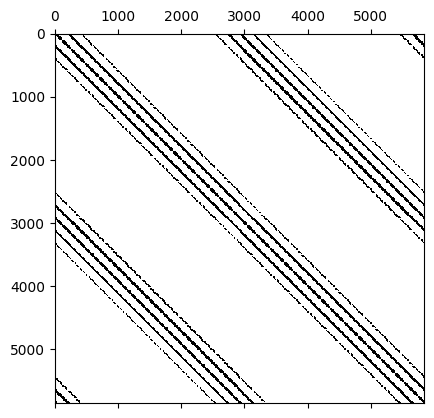

In [212]:
Hk = H.Hk(k=(0,0,0), format='dense')
plt.spy(Hk)

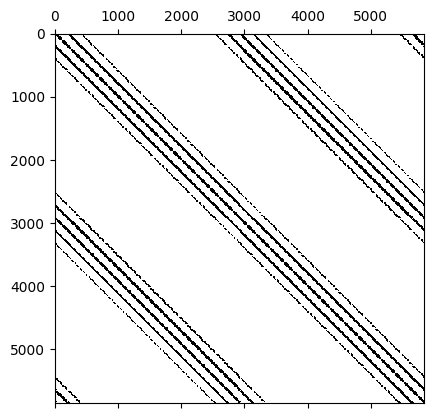

In [213]:
Hk1 = H1.Hk(k=(0,0,0), format='dense')
plt.spy(Hk1)

/tmp/ipykernel_1351569/3905390504.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')


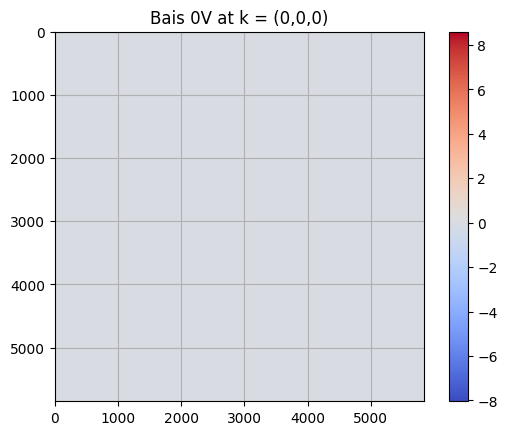

In [214]:
tmp = (H1-H).Hk(k=(1,1,0), format='dense').real
#哈密顿矩阵误差对比图
min_value = np.min(tmp)
max_value = np.max(tmp)
cmap = plt.cm.get_cmap('coolwarm')
plt.imshow(tmp, cmap=cmap, vmin=min_value, vmax=max_value)
# plt.imshow(tmp, cmap=cmap, vmin=-0.003, vmax=0.003)
# plt.imshow(Sk, cmap=cmap)
plt.colorbar()
plt.grid()
plt.title("Bais 0V at k = (0,0,0)")
plt.show()

In [76]:
#判断单步计算的重叠矩阵和完全自洽收敛的重叠矩阵是否相同
sum = 0
for i in range(100):
    for j in range(100):
        sum = sum + int(S[i,j] == S_rotate_pred[(0, 0, 0)][i,j])
print(sum) #1000000，证明相同

9836


In [24]:
#非零元素的迭代，哈密顿量矩阵的非零元和重叠矩阵的非零元在相同位置。注意有的非零元并不是元素就不为0.0，有可能为0.0的。
for i, j in H.H.iter_nnz():
    print(i,j,H.H[i, j])
    if i == 1:
        break
print("===================")      
for i, j in H.S.iter_nnz():
    print(i,j,H.S[i, j])
    if i == 1:
        break

0 0 -16.671743
0 1 -15.209539
0 2 1.6026097e-10
0 3 5.9945117e-12
0 4 -3.9583983e-06
0 5 1.5312958e-10
0 6 -8.096786e-15
0 7 1.6023214e-05
0 8 8.0164285e-11
0 9 -6.594672e-16
0 10 3.987501
0 11 3.1229143e-15
0 12 -6.667153e-05
0 13 -8.590371
0 14 -7.4931483
0 15 -7.936093
0 16 2.9064281e-12
0 17 -4.581863
0 18 -6.079959
0 19 5.5757444e-13
0 20 -3.5102239
0 21 -4.0663214
0 22 8.36489e-12
0 23 3.3662298
0 24 4.8313623e-12
0 25 2.3477206
0 26 -1.5785471
0 27 -0.9407653
0 28 -1.3792067
0 29 6.808594e-13
0 30 -2.6867764
0 31 -0.63302195
0 32 2.0511414e-13
0 33 -1.1787986
0 34 -2.521093
0 35 9.341225e-13
0 36 1.9220792
0 37 1.7030589e-12
0 38 -1.960592
0 39 -0.56459373
0 40 -0.2691765
0 41 -2.904776e-12
0 42 2.193762e-13
0 43 -1.3822397
0 44 -4.886646e-13
0 45 2.97893e-14
0 46 -0.43959665
0 47 -8.836505e-12
0 48 6.940965e-18
0 49 1.0700573
0 50 7.2387246e-13
0 51 -1.6738365
0 52 -1.578661
0 53 -0.9407545
0 54 -3.0162857
0 55 6.8091556e-13
0 56 0.14894314
0 57 -1.3374051
0 58 2.0501566e-13
0 

In [60]:
index = H.H.nonzero()
print(index[0].shape)
print(index[1].shape)
index = S.S.nonzero()
print(index[0].shape)
print(index[1].shape)

(2770650,)
(2770650,)
(2770650,)
(2770650,)


In [35]:
index = np.nonzero(H.S)
print(index[0])
print(index[1])

[   0    0    0 ... 2495 2495 2495]
[    0     1     2 ... 20030 20031 20032]


In [38]:
S_nonzero_indices = H.S.nonzero()
for i in range(S_nonzero_indices[0].shape[0]):
    H_empty.S[S_nonzero_indices[0][i], S_nonzero_indices[1][i]] = H.S[S_nonzero_indices[0][i], S_nonzero_indices[1][i]]

In [40]:
nonzero_index = np.nonzero(H_R[(0,0,0)])
print(nonzero_index[0])
print(nonzero_index[0].shape)
print(nonzero_index[1])
print(nonzero_index[1].shape)
print(nonzero_index[0].shape[0])

[   0    0    0 ... 2495 2495 2495]
(941668,)
[   0    1    2 ... 2493 2494 2495]
(941668,)
941668


In [41]:
#方法一：把H_R中真正的非零元素都复制到H_pred中，这种方法得到的态密度很好，能带一塌糊涂
n = H_empty.shape[0]
for key in H_R.keys():
    print(key)
    if key == (-1, -1, 0):
        no = 8 * n
    elif key == (-1, 0, 0):
        no = 4 * n
    elif key == (-1, 1, 0):
        no = 6 * n
    elif key == (0, -1, 0):
        no = 2 * n
    elif key == (0, 0, 0):
        no = 0 * n
    elif key == (0, 1, 0):
        no = 7 * n
    elif key == (1, -1, 0):
        no = 3 * n
    elif key == (1, 0, 0):
        no = 5 * n
    elif key == (1, 1, 0):
        no = 1 * n
    nonzero_index = np.nonzero(H_R[key].real)
    for i in range(nonzero_index[0].shape[0]):
        H_empty.H[nonzero_index[0][i], nonzero_index[1][i]+no] = H_R[key][nonzero_index[0][i], nonzero_index[1][i]].real

(-1, -1, 0)
(-1, 0, 0)
(-1, 1, 0)
(0, -1, 0)
(0, 0, 0)
(0, 1, 0)
(1, -1, 0)
(1, 0, 0)
(1, 1, 0)


### siesta计算和预测的费米能级对比

In [234]:
#设置电荷数目，C的电子排布式是1s22s22p2，所以是在sp轨道上，价电子为2s2 2p2C元素；
#一般最外层有2个价电子，所以系统中填充电子的总数是8000*2=1600个电子
real_fermi_level = H.fermi_level(q=900, distribution='fermi_dirac')
print(real_fermi_level)
pred_fermi_level = H1.fermi_level(q=905, distribution='fermi_dirac')
print(pred_fermi_level)

-3.6517618894577026
-3.6133919954299927


### siesta计算的布里渊区上的平均态密度

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 假设你已经有哈密顿量矩阵 H，计算本征值
# H = np.array(...)  # 你的哈密顿量矩阵

# 计算本征能量
eigvals, eigvecs = np.linalg.eigh(H)  # eigvals 是本征能量

# 设置能量范围
E_min = -10  # 最小能量
E_max = 5    # 最大能量
num_points = 100  # 计算点的数量

# 创建能量网格
E = np.linspace(E_min, E_max, num_points)

# 假设化学势为费米能级，通常设定一个值
mu = 0  # 设定化学势（费米能级）
kT = 0.0259  # 设定温度相关常数（假设室温）

# 计算态密度
def fermi_distribution(E, mu, kT):
    return 1.0 / (np.exp((E - mu) / kT) + 1)

# 计算每个能量点的DOS（通过费米分布函数加权）
DOS = np.zeros_like(E)

for i, energy in enumerate(E):
    # 对每个能量点，计算态密度
    DOS[i] = np.sum(fermi_distribution(eigvals, mu, kT))

# 绘制态密度图
plt.plot(E, DOS)
plt.xlabel("$E - E_F$ [eV]")
plt.ylabel("DOS [1/eV]")
plt.grid()
plt.show()


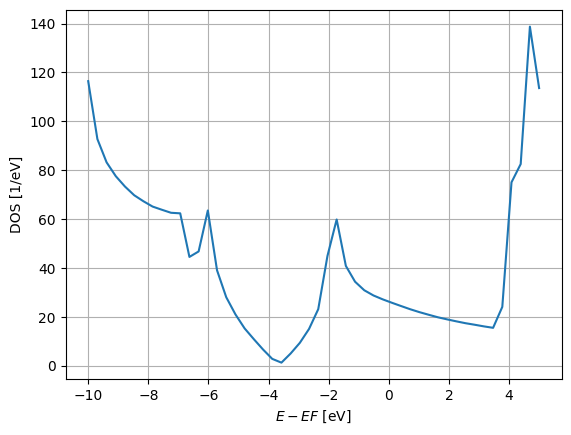

In [110]:
plt.figure()
es1 = H.eigenstate()
bz1 = MonkhorstPack(H, [5,5,1])
bz_average1 = (bz1.apply.average)
E = np.linspace(-10,5,50)
plt.plot(E, bz_average1.eigenstate(wrap=lambda es1: es1.DOS(E)))
plt.xlabel("$E - EF$ [eV]")
plt.ylabel("DOS [1/eV]")
plt.grid()
# plt.savefig('/fs2/home/ndsim10/example/work_dir/olp/5_4/DOS.png', dpi=300)
plt.show()

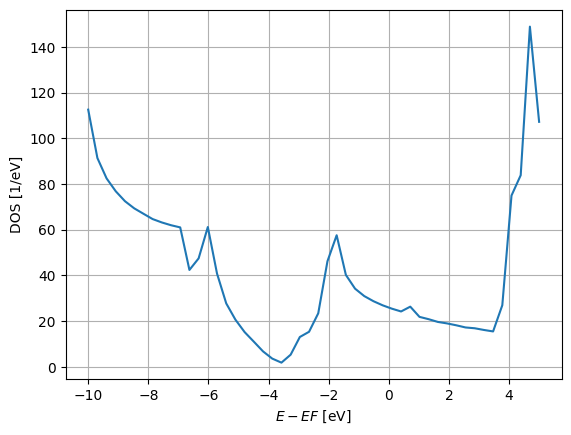

计算时间: 486.8319 秒


In [124]:
import time
# 记录开始时间
start_time = time.time()
plt.figure()
es2 = H1.eigenstate()
bz2 = MonkhorstPack(H1, [5,5,1])
bz_average2 = (bz2.apply.average)
E = np.linspace(-10,5,50)
plt.plot(E, bz_average2.eigenstate(wrap=lambda es2: es2.DOS(E)))
plt.xlabel("$E - EF$ [eV]")
plt.ylabel("DOS [1/eV]")
plt.grid()
# plt.savefig('/fs2/home/ndsim10/example/work_dir/olp/5_4/DOS.png', dpi=300)
plt.show()

# 记录结束时间
end_time = time.time()
# 打印计算所用时间
print(f"计算时间: {end_time - start_time:.4f} 秒")

### sisl计算的和预测的态密度对比图

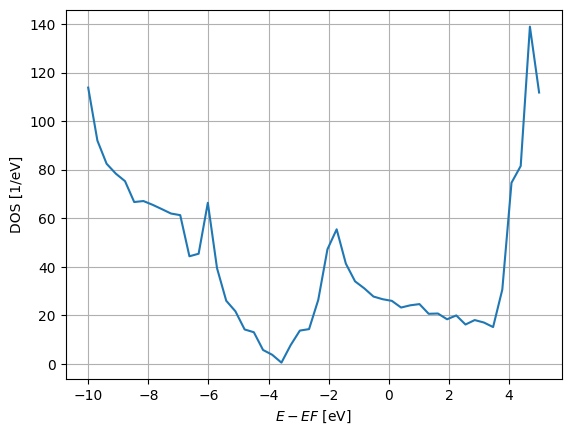

计算时间: 110.5542 秒


In [87]:
import time
# 记录开始时间
start_time = time.time()

plt.figure()
bz = MonkhorstPack(H1, [5,5,1])
E = np.linspace(-10,5,50)
eig = bz.apply.average.eigh()
dos = physics.electron.DOS(E, eig.real)
plt.plot(E, dos)
plt.xlabel("$E - EF$ [eV]")
plt.ylabel("DOS [1/eV]")
plt.grid()
# plt.savefig('/fs2/home/ndsim10/example/work_dir/olp/5_4/DOS.png', dpi=300)
plt.show()
# 记录结束时间
end_time = time.time()
# 打印计算所用时间
print(f"计算时间: {end_time - start_time:.4f} 秒")

In [ ]:
plt.figure()
# es1 = H.eigenstate()
# bz1 = MonkhorstPack(H, [5,5,1])
# bz_average1 = (bz1.apply.average)
# E = np.linspace(-10,5,50)
# dos1 = bz_average1.eigenstate(wrap=lambda es1: es1.DOS(E))
plt.plot(E, dos1)
plt.plot(E, dos)

plt.xlabel("$E - EF$ [eV]")
plt.ylabel("DOS [1/eV]")
plt.grid()

# plt.savefig('/fs2/home/ndsim10/example/work_dir/olp/5_4/DOS.png', dpi=300)
plt.show()

### siesta计算的PDOS

In [131]:
es = H.eigenstate(k=(0, 0, 0))
E = np.linspace(-10, 5, 100)
# E = np.linspace(-1, -0.5, 50)
dE = E[1] - E[0]
PDOS = es.PDOS(E)  #PDOS：(1, 5850, 50)，np.array类型
# PDOS = es.PDOS(E)
print(PDOS.shape)

(1, 5850, 100)


(5850, 100)
(13, 100)


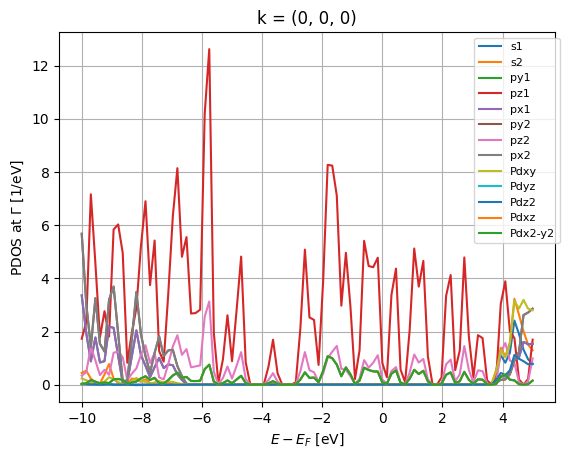

In [132]:
PDOS_data = PDOS.sum((0)) * dE  #PDOS：(1, 5850, 50)，np.array类型
print(PDOS_data.shape)
pdos = np.zeros((13,100))
for i in range(13):
    for j in range(450): #800个原子
        pdos[i,:] = pdos[i,:] + PDOS_data[i+13*j,:]
# print(pdos)
print(pdos.shape)
plt.grid()
plt.plot(E, pdos[0,:], label='s1')
plt.plot(E, pdos[1,:], label='s2')
plt.plot(E, pdos[2,:], label='py1')
plt.plot(E, pdos[3,:], label='pz1')
plt.plot(E, pdos[4,:], label='px1')
plt.plot(E, pdos[5,:], label='py2')
plt.plot(E, pdos[6,:], label='pz2')
plt.plot(E, pdos[7,:], label='px2')
plt.plot(E, pdos[8,:], label='Pdxy')
plt.plot(E, pdos[9,:], label='Pdyz')
plt.plot(E, pdos[10,:], label='Pdz2')
plt.plot(E, pdos[11,:], label='Pdxz')
plt.plot(E, pdos[11,:], label='Pdx2-y2')
plt.legend(bbox_to_anchor=(1.02, 1), fontsize = 8)
plt.title(r"k = (0, 0, 0)")
plt.xlabel(r"$E - E_F$ [eV]")
plt.ylabel(r"PDOS at $\Gamma$ [1/eV]")
plt.show()

In [226]:
es = H.eigenstate()
E = np.linspace(-5, -2, 50)
dE = E[1] - E[0]
PDOS = es.PDOS(E).sum((0, 2)) * dE  # perform integration
normalize = np.linalg.norm(PDOS, np.inf)
normalize = PDOS / normalize
geom1.plot(axes="xy", atoms_style={"size": normalize})
# plt.scatter(system.xyz[:, 0], system.xyz[:, 1], 500 * PDOS);
# plt.scatter(xyz_remove[0], xyz_remove[1], c='k', marker='*'); # mark the removed atom

/fs2/software/python/3.9_anaconda_2022.05/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning:

Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.

/fs2/software/python/3.9_anaconda_2022.05/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning:

Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.



### siesta计算的能带

[0.         0.00578006 0.01156012 0.01734017 0.02312023 0.02890029
 0.03468035 0.0404604  0.04624046 0.05202052 0.05780058 0.06358063
 0.06936069 0.07514075 0.08092081 0.08670086 0.09248092 0.09826098
 0.10456442 0.11086787 0.11717131 0.12347476 0.1297782  0.13608165
 0.14238509 0.14868854 0.15499198 0.16096366 0.16693535 0.17290703
 0.17887872 0.1848504  0.19082209 0.19679377 0.20276546 0.20873714
 0.21470882 0.22068051 0.22665219 0.23262388 0.23859556 0.24456725
 0.25053893 0.25651061 0.2624823  0.26845398] [0.         0.09826098 0.15499198 0.26845398] ['Γ', 'M', 'K', 'Γ']
[[-23.096626 -23.002388 -23.002312 ... 199.62103  222.1622   222.17583 ]
 [-23.096062 -23.00778  -23.004986 ... 200.65602  222.16597  222.18329 ]
 [-23.09542  -23.013086 -23.00779  ... 201.68932  222.09549  222.10944 ]
 ...
 [-23.095444 -23.012016 -23.011799 ... 201.5037   222.07617  222.09586 ]
 [-23.096184 -23.007114 -23.006838 ... 200.56834  222.16495  222.17267 ]
 [-23.096626 -23.002388 -23.002312 ... 199.62103

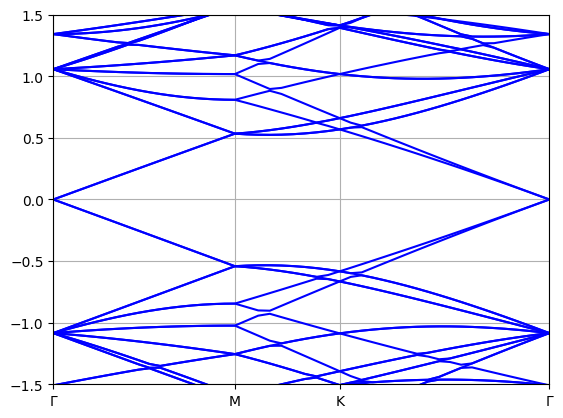

In [112]:
import time
# 记录开始时间
start_time = time.time()
bs = BandStructure(
    H,
    [[0,0,0], [0.5,0,0], [0.33333333,0.33333333,0], [0,0,0]],
    46,
    [r"Γ", r"M", r"K", r"Γ"]
)
lk, kt, kl = bs.lineark(True)
print(lk, kt, kl)
bs_eig = bs.apply.array.eigh()
print(bs_eig)
print(bs_eig.shape)
for i in range(bs_eig.shape[1]):
    plt.plot(lk, bs_eig[:, i] - real_fermi_level, color='blue')
# plt.plot(bs.lineark(), bs_eig, color='blue')
plt.ylim(-1.5, 1.5)
plt.xlim(kt[0], kt[-1])
plt.xticks(kt, kl)
plt.grid()
plt.show()
# 记录结束时间
end_time = time.time()
# 打印计算所用时间
print(f"计算时间: {end_time - start_time:.4f} 秒")

### TGCN预测的能带

[0.         0.00578006 0.01156012 0.01734017 0.02312023 0.02890029
 0.03468035 0.0404604  0.04624046 0.05202052 0.05780058 0.06358063
 0.06936069 0.07514075 0.08092081 0.08670086 0.09248092 0.09826098
 0.10456442 0.11086787 0.11717131 0.12347476 0.1297782  0.13608165
 0.14238509 0.14868854 0.15499198 0.16096366 0.16693535 0.17290703
 0.17887872 0.1848504  0.19082209 0.19679377 0.20276546 0.20873714
 0.21470882 0.22068051 0.22665219 0.23262388 0.23859556 0.24456725
 0.25053893 0.25651061 0.2624823  0.26845398] [0.         0.09826098 0.15499198 0.26845398] ['Γ', 'M', 'K', 'Γ']
[[-3001.8984   -900.82336  -227.39615 ...   462.67923   538.0365
    749.73004]
 [-3001.9434   -900.7922   -227.37991 ...   462.67834   538.0925
    749.7688 ]
 [-3002.0059   -900.8386   -227.37912 ...   462.6887    538.0902
    749.82904]
 ...
 [-3001.916    -900.89777  -227.38672 ...   462.6975    538.1046
    749.8534 ]
 [-3002.1577   -900.9065   -227.37799 ...   462.67056   538.09534
    749.83453]
 [-3001.8984

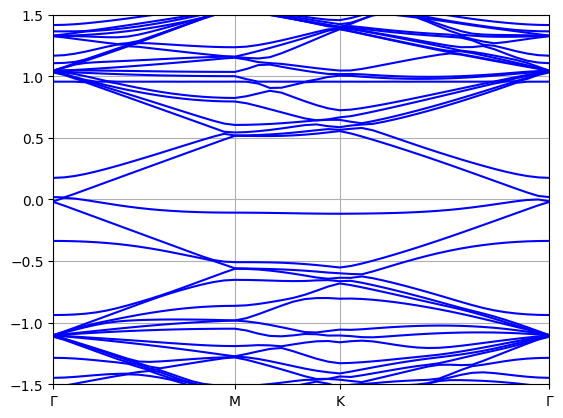

计算时间: 441.4819 秒


In [235]:
import time
# 记录开始时间
start_time = time.time()
bs = BandStructure(
    H1,
    [[0,0,0], [0.5,0,0], [0.33333333,0.33333333,0], [0,0,0]],
    46,
    [r"Γ", r"M", r"K", r"Γ"]
)
lk, kt, kl = bs.lineark(True)
print(lk, kt, kl)
bs_eig = bs.apply.array.eigh()
print(bs_eig)
print(bs_eig.shape)
for i in range(bs_eig.shape[1]):
    plt.plot(lk, bs_eig[:, i] - real_fermi_level, color='blue')
# plt.plot(bs.lineark(), bs_eig, color='blue')
plt.ylim(-1.5, 1.5)
plt.xlim(kt[0], kt[-1])
plt.xticks(kt, kl)
plt.grid()
plt.show()
# 记录结束时间
end_time = time.time()
# 打印计算所用时间
print(f"计算时间: {end_time - start_time:.4f} 秒")

### TGCN预测的GAMMA点处的态密度

[8.06698217e+00 2.33339627e+01 4.67177828e+01 1.22775442e+01
 4.19214193e-01 1.85973998e-03 9.36489140e-05 3.71565898e-02
 1.93755073e+00 1.31266846e+01 1.15542498e+01 1.32133574e+00
 1.96322191e-02 5.18399800e-05 1.27328941e-02 1.51077419e+00
 2.32956924e+01 4.74152633e+01 2.38945680e+01 2.37055916e+01
 7.61217838e+00 2.47896504e+01 7.13532412e+01 7.34243712e+01
 7.69510713e+01 4.12137259e+01 3.06390194e+01 4.64129671e+01
 1.14316528e+01 1.76075613e+00 2.26148442e+01 5.25186359e+01
 3.86136229e+01 4.34569319e+01 4.34912681e+01 7.74081904e+00
 2.13753694e+00 2.61342896e+01 4.53618174e+01 1.02304486e+01
 5.14495894e-01 8.49416242e+00 4.39050385e+01 3.79799126e+01
 4.39186887e+01 3.00729733e+01 3.35553707e+00 5.49031640e-02
 9.18989284e-02 5.17975201e+00]


Text(0, 0.5, 'DOS at $\\Gamma$ [1/eV]')

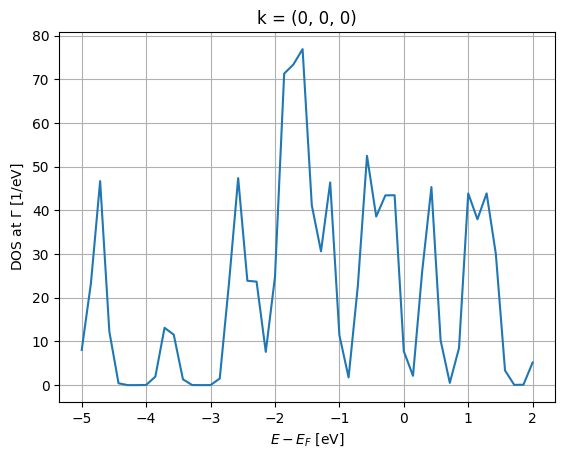

In [109]:
es = H.eigenstate(k=(0, 0, 0))
E = np.linspace(-5, 2, 0)
print(es.DOS(E))
plt.grid()
plt.plot(E, es.DOS(E))
plt.title(r"k = (0, 0, 0)")
plt.xlabel(r"$E - E_F$ [eV]")
plt.ylabel(r"DOS at $\Gamma$ [1/eV]")

Text(0, 0.5, 'DOS at $\\Gamma$ [1/eV]')

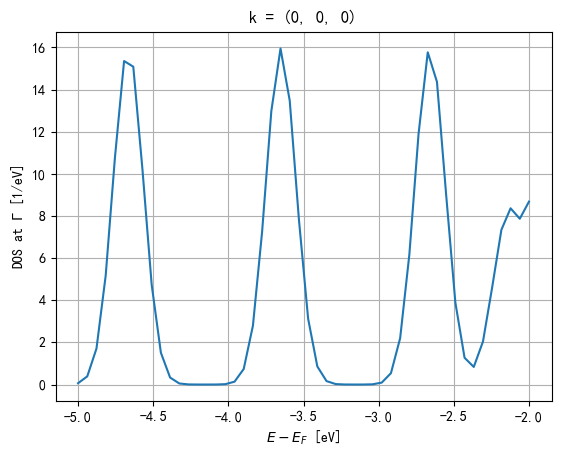

In [48]:
es = H_empty.eigenstate(k=(0, 0, 0))
E = np.linspace(-5, -2, 50)
# print(es.DOS(E))
plt.grid()
plt.plot(E, es.DOS(E))
plt.title(r"k = (0, 0, 0)")
plt.xlabel(r"$E - E_F$ [eV]")
plt.ylabel(r"DOS at $\Gamma$ [1/eV]")

[212.85294254+0.j 200.51509616+0.j 192.49739917+0.j ...  13.01852423+0.j
  13.01816818+0.j  13.01826373+0.j]
[6.22550119e-02 3.90227764e-01 1.71489130e+00 5.18142223e+00
 1.07614249e+01 1.53637819e+01 1.50776632e+01 1.01713240e+01
 4.71659392e+00 1.50344323e+00 3.29422403e-01 4.96165760e-02
 5.13707820e-03 3.69070417e-04 1.03521073e-04 1.44988061e-03
 1.68604111e-02 1.34835163e-01 7.41238799e-01 2.80112663e+00
 7.27657423e+00 1.29939387e+01 1.59504997e+01 1.34594529e+01
 7.80728722e+00 3.11309623e+00 8.53305557e-01 1.60781563e-01
 2.08251673e-02 1.85595175e-03 1.59782727e-04 8.49780625e-04
 1.06022793e-02 9.14398034e-02 5.42106651e-01 2.20923533e+00
 6.18880790e+00 1.19173532e+01 1.57746791e+01 1.43533150e+01
 8.97899469e+00 3.87723867e+00 1.26475855e+00 8.33801033e-01
 2.04101878e+00 4.61671872e+00 7.34297468e+00 8.36631139e+00
 7.86919293e+00 8.68650020e+00]


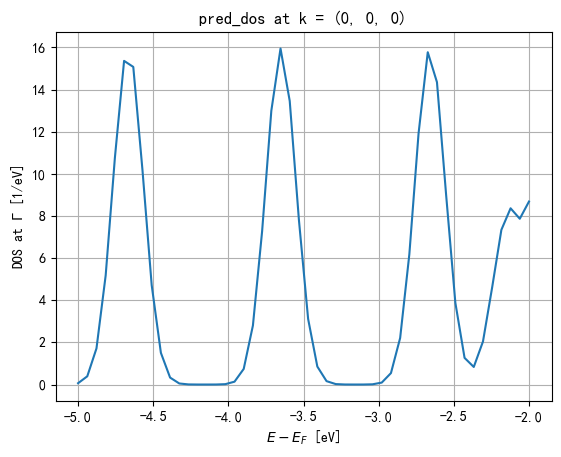

In [61]:
from sisl.physics.electron import *

# 假设 H_empty 已经被正确定义
# 定义能量范围
E = np.linspace(-5, -2, 50)

# 计算特定 k 点的本征值
eig = H_empty.eig(k=(0, 0, 0))
# eig = H_empty.eig(k=(0.33333333, 0.33333333, 0))
print(eig)

# 计算并打印态密度
dos = DOS(E, eig.real)
print(dos)

# 绘制态密度图
plt.plot(E, dos)
plt.grid()
plt.title(r"pred_dos at k = (0, 0, 0)")
plt.xlabel(r"$E - E_F$ [eV]")
plt.ylabel(r"DOS at $\Gamma$ [1/eV]")
plt.show()

### 哈密顿矩阵误差对比图

In [235]:
tmp = H.Hk(k=(0,0,0),format='dense') - H_empty.Hk(k=(0,0,0), format='dense')
print(type(tmp))

<class 'numpy.ndarray'>


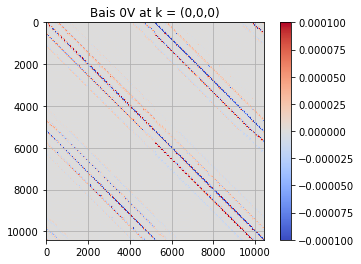

In [239]:
#哈密顿矩阵误差对比图
min_value = np.min(tmp)
max_value = np.max(tmp)
cmap = plt.cm.get_cmap('coolwarm')
# plt.imshow(tmp, cmap=cmap, vmin=min_value, vmax=max_value)
plt.imshow(tmp, cmap=cmap, vmin=-0.0001, vmax=0.0001)
# plt.imshow(Sk, cmap=cmap)
plt.colorbar()
plt.grid()
plt.title("Bais 0V at k = (0,0,0)")
plt.show()

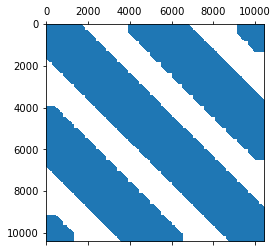

In [237]:
plt.spy(H_empty.Hk(k=(0,0,0)))

In [ ]:
# 创建一个 tshsSileSiesta 对象来写入文件
# 您需要指定要写入的文件名和模式
tshs_file = siesta.tshsSileSiesta("/fs2/home/ndsim10/deeph/example/work_dir/inference/5_4/test.TSHS", mode='w')

# 使用 write_hamiltonian 方法将数据写入文件
tshs_file.write_hamiltonian(tmp)

### 验证单步自洽计算出的重叠矩阵和电子结构自洽收敛的重叠矩阵一样。

In [ ]:
S_pred = S_R[(0, 0, 0)]
print(np.max(S_pred))
print(np.min(S_pred))
plt.spy(S_pred)

In [ ]:
tmp = np.zeros((5850,5850))
for i in range(5850):
    k = 0
    for j in range(40950,46800):
        tmp[i,k] = H.H[i, j]
        k = k+1
plt.spy(tmp)

In [ ]:
# 现在你可以传递这些numpy数组到linalg.eigvalsh
egval = linalg.eigvalsh(H_matrix, S_matrix)
print(egval)
print(egval.shape)